Mount drive

In [28]:
#Mount Google Drive for accessing netflix data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [2]:
#Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import PReLU

In [3]:
#Some variables
data_dir = "drive/MyDrive/netflix" #replace with the directory that contains your Netflix prize data
model_dir = "drive/MyDrive/models" #replace this with the directory where you would like to save your NCF model files

Load Netflix Prize Data

In [4]:
#Function to load all of the netflix prize data into a pandas df
def load_netflix_data(file_paths):
    data = {'user': [], 'item': [], 'label': []}
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            movie_id = None
            for line in file:
                line = line.strip()
                if line.endswith(':'):
                    movie_id = int(line[:-1])
                else:
                    customer_id, rating, _ = line.split(',')
                    data['item'].append(movie_id)
                    data['user'].append(int(customer_id))
                    data['label'].append(int(rating))
    return pd.DataFrame(data)

In [5]:
#Use the function above to load the data into a df
data_files = [f'{data_dir}/combined_data_{i}.txt' for i in range(1, 5)]
df = load_netflix_data(data_files)

In [6]:
#Examine the df
df.head()

,user,item,label
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3


Separate out the Probe data for testing and the rest of the data for training

In [7]:
#Function to load the probe.txt file (which contains a list of user/movie pairs to be held off and used for testing), into a pandas df
def load_probe(file_path):
    """Load `probe.txt` or `qualifying.txt` into a DataFrame."""
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Ignore empty or non-data lines
            line = line.strip()
            if line.endswith(':'):  # Skip MovieID lines
                current_movie_id = int(line[:-1])
            else:
                # CustomerID, MovieID
                customer_id = int(line)
                data.append({'item': current_movie_id, 'user': customer_id})
    return pd.DataFrame(data)

In [8]:
#Load the list of test user/movie pairs
probe_path = f'{data_dir}/probe.txt'
probe_df = load_probe(probe_path)

In [9]:
#Join the list of test user/movie pairs to the dataframe to create a df that contains the test user/movie pairs with the ground truth rating info
df_test = probe_df.merge(df, on=['item', 'user'], how='inner')

In [10]:
# Perform an anti-join to keep rows in df that are not in df_test
df_train = pd.merge(
    df,
    df_test,
    on=['user', 'item'],
    how='left',
    indicator=True
)

# Keep only rows that are present in df but not in df_test
df_train = df_train[df_train['_merge'] == 'left_only'].drop(columns='_merge')

df_train = df_train.rename(columns={'label_x': 'label'}).drop(columns=['label_y'], errors='ignore')


In [11]:
#Shuffle the training dataframe
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [12]:
#Shuffle the testing dataframe
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [13]:
#Examine the training dataframe
df_train.head()

,user,item,label
0,562597,3385,4
1,2542613,16784,3
2,190197,15436,5
3,1434766,12732,4
4,331447,7511,4


In [14]:
#Examine the testing dataframe
df_test.head()

,item,user,label
0,5071,2237919,3
1,4740,100168,5
2,2342,1637087,5
3,3282,2446059,3
4,7233,1622181,4


In [15]:
#Show the number of training, testing, and total samples
print("Number of ALL samples:", len(df))
print("Number of train samples:", len(df_train))
print("Number of test samples:    ", len(df_test))

Number of ALL samples: 100480507
Number of train samples: 99072112
Number of test samples:     1408395


In [16]:
#Compress the range of user IDs

# Step 1: Get all unique user IDs from both datasets
unique_users = pd.concat([df_train["user"], df_test["user"]]).dropna().unique()

# Step 2: Create a mapping from old IDs to new consecutive IDs
user_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_users))}

# Step 3: Apply the mapping to train and test sets
df_train["user"] = df_train["user"].map(user_id_map)
df_test["user"] = df_test["user"].map(user_id_map)

Get things ready for TF

In [17]:

# Convert user, item, and label columns to numpy arrays for TensorFlow
train_user = df_train['user'].values
train_item = df_train['item'].values
train_label = df_train['label'].values.astype(np.float32)  # ensure float for regression

test_user = df_test['user'].values
test_item = df_test['item'].values
test_label = df_test['label'].values.astype(np.float32)

# Confirm shapes
print("train_user shape:", train_user.shape)
print("train_item shape:", train_item.shape)
print("train_label shape:", train_label.shape)

print("test_user shape:", test_user.shape)
print("test_item shape:", test_item.shape)
print("test_label shape:", test_label.shape)

# Compute maximum user and item IDs (add 1 to handle indexing)
max_user_id = np.max(train_user) + 1
max_item_id = np.max(train_item) + 1

print("Max user ID:", max_user_id)
print("Max item ID:", max_item_id)

train_user shape: (99072112,)
train_item shape: (99072112,)
train_label shape: (99072112,)
test_user shape: (1408395,)
test_item shape: (1408395,)
test_label shape: (1408395,)
Max user ID: 480189
Max item ID: 17771


Set hyperparameters

In [18]:
#User embedding size
embedding_dim_user = 32
#Item embedding size
embedding_dim_item = 32

#User tower hidden layers node counts
dense_units_user_1 = 32
dense_units_user_2 = 16

#Item tower hidden layers node counts
dense_units_item_1 = 32
dense_units_item_2 = 16

#Learning rate
learning_rate = 0.0003

#Parametric ReLU as activation for all hidden layers in both towers (this performs best)
activation_user_1 = PReLU()
activation_user_2 = PReLU()

activation_item_1 = PReLU()
activation_item_2 = PReLU()

Create the model

In [19]:
# Two input layers
user_input = keras.Input(shape=(), name='user_input', dtype=tf.int32)
item_input = keras.Input(shape=(), name='item_input', dtype=tf.int32)

# User tower
user_embedding_layer = layers.Embedding(
    input_dim=max_user_id,
    output_dim=embedding_dim_user,
    name='user_embedding'
)(user_input)

#Flatten the user embedding
user_vec = layers.Flatten(name='flatten_user')(user_embedding_layer)

#User tower dense layers
user_vec = layers.Dense(dense_units_user_1, activation=activation_user_1, name='user_dense1')(user_vec)
user_vec = layers.Dense(dense_units_user_2, activation=activation_user_2, name='user_dense2')(user_vec)


# Item tower
item_embedding_layer = layers.Embedding(
    input_dim=max_item_id,
    output_dim=embedding_dim_item,
    name='item_embedding'
)(item_input)

#flatten the item embedding
item_vec = layers.Flatten(name='flatten_item')(item_embedding_layer)

#Item tower dense layers
item_vec = layers.Dense(dense_units_item_1, activation=activation_item_1, name='item_dense1')(item_vec)
item_vec = layers.Dense(dense_units_item_2, activation=activation_item_2, name='item_dense2')(item_vec)

#Dot the resulatant user vector and the resultant item vector
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final output.  Give the output a slope and intercept to let the model adjust itself
rating_prediction = layers.Dense(1, activation='linear', name='rating_prediction')(dot_user_item)

train the model

In [20]:
#Create the model
model = keras.Model(
    inputs=[user_input, item_input],
    outputs=rating_prediction
)

In [21]:
#Examine the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 32)             │     15,366,048 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 32)             │        568,672 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_user (Flatten)    │ (None, 32)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_item (Flatten)    │ (None, 32)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense1 (Dense)       │ (None, 32)             │          1,056 │ flatten_user[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense1 (Dense)       │ (None, 32)             │          1,056 │ flatten_item[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense2 (Dense)       │ (None, 16)             │            528 │ user_dense1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense2 (Dense)       │ (None, 16)             │            528 │ item_dense1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_user_item (Dot)       │ (None, 1)              │              0 │ user_dense2[0][0],     │
│                           │                        │                │ item_dense2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_prediction (Dense) │ (None, 1)              │              2 │ dot_user_item[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,937,890 (60.80 MB)

 Trainable params: 15,937,890 (60.80 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

print("Model compiled successfully.")

Model compiled successfully.


In [23]:
#Use early stopping during training to get the lowest rmse if the model starts to overfit

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_rmse',       # or 'val_loss'
    mode='min',               # we want to minimize RMSE
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [24]:
#Train the model (Started with 20 epochs, but stopping after the overfitting starts at 3 gives better results)
batch_size = 512
epochs = 3

history = model.fit(
    x=[train_user, train_item],
    y=train_label,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop],
    validation_split=0.1,  # 10% of training data used for validation
    verbose=1
)

Epoch 1/3
174151/174151 ━━━━━━━━━━━━━━━━━━━━ 473s 3ms/step - loss: 0.8770 - rmse: 0.9317 - val_loss: 0.7339 - val_rmse: 0.8567
Epoch 2/3
174151/174151 ━━━━━━━━━━━━━━━━━━━━ 470s 3ms/step - loss: 0.7080 - rmse: 0.8414 - val_loss: 0.7092 - val_rmse: 0.8421
Epoch 3/3
174151/174151 ━━━━━━━━━━━━━━━━━━━━ 470s 3ms/step - loss: 0.6763 - rmse: 0.8224 - val_loss: 0.6991 - val_rmse: 0.8361
Restoring model weights from the end of the best epoch: 3.


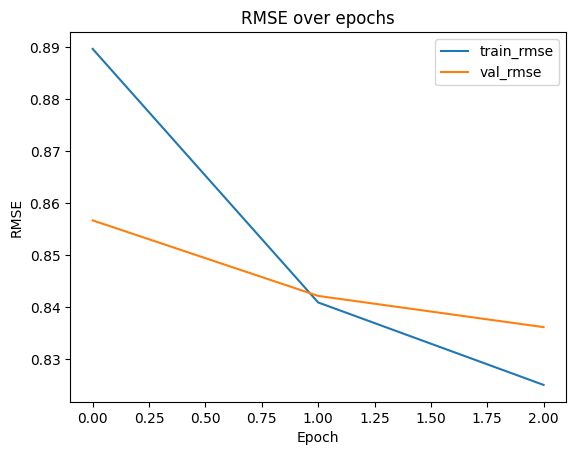

In [25]:
#Plot the training set RMSE and the val set RMSE

plt.plot(history.history['rmse'], label='train_rmse')
plt.plot(history.history['val_rmse'], label='val_rmse')
plt.title('RMSE over epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Save the model

In [26]:
#Save the model
model.save(f"{model_dir}/two_tower_model3.h5")

test the model

In [27]:
#Test the model on the held off test set (Probe.txt file.)
predictions = model.predict([test_user, test_item])
mse = np.mean((predictions.flatten() - test_label)**2)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

44013/44013 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step
RMSE:  0.931497
